In [1]:
from kinetic_measure import *
import plot_property_map as ppm
import pynbody
import numpy as np
import scipy.optimize as so
import scipy.stats as ss
import os
from matplotlib.patches import Ellipse


In [2]:
savedir = '/home/seoyoung/analysis/figure/'

simdir = '/project/rrg-babul-ad/rennehan/romulus_data/h1.cosmo50/'
param_file = '/project/rrg-babul-ad/rennehan/romulus_data/h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.param'

filelist = os.listdir(simdir)

result = [i[-6:] for i in filelist if i.startswith('h1.cosmo50') and len(i)==35]
result.sort()

In [4]:
filt_size = 35
n_dir = 10
nbins = 15
width = 11 #kpc/h unit
#snap = result[::-1][0]
snap = result[-27] #redshift 0.4


data_file = '/project/rrg-babul-ad/rennehan/romulus_data/h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.'+snap
s = pynbody.load(data_file, paramfile = param_file)
s.physical_units()

print("get halos")
h = s.halos()
h0 = h[0]
pynbody.analysis.halo.center(h0,mode='hyb')



get halos


In [7]:
shape = pynbody.analysis.halo.galaxy_shape(s_filt, rout = 15)

In [8]:
shape[1]

14.82335676708197

14.82335676708197
10.552404916355133
3.106253799534772


(-20.0, 40.0, -40.0, 20.0)

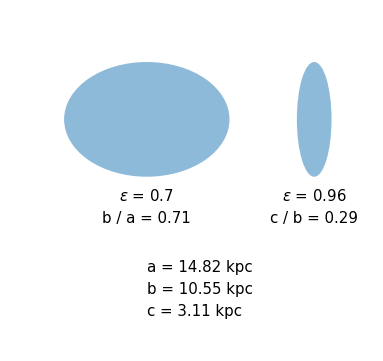

In [11]:
print(shape[1]) #b/a
print(shape[2]) #c/a
print(shape[3]) #c/b

a = shape[1]
b = shape[2]
c = shape[3]

plt.figure(figsize = (6,6))
ell = Ellipse((0,0), 2 * a, 2 * b, alpha = 0.5)
plt.gca().add_artist(ell)

ell = Ellipse((30,0), 2 * c, 2 * b, alpha = 0.5)
plt.gca().add_artist(ell)

plt.xlim(-20,40)
plt.ylim(-40,20)

plt.text(0,-28,"a = "+str(round(a,2))+" kpc",fontsize = 15, horizontalalignment = 'left')
plt.text(0,-32,"b = "+str(round(b,2))+" kpc",fontsize = 15, horizontalalignment = 'left')
plt.text(0,-36,"c = "+str(round(c,2))+" kpc",fontsize = 15, horizontalalignment = 'left')

plt.text(0,-15,"$\\epsilon$ = "+str(round(np.sqrt(1-(b/a)**2),2)),fontsize = 15, horizontalalignment = 'center' )
plt.text(0,-19,"b / a = "+str(round(b/a,2)),fontsize = 15, horizontalalignment = 'center' )

plt.text(30,-15,"$\\epsilon$ = "+str(round(np.sqrt(1-(c/b)**2),2)),fontsize = 15, horizontalalignment = 'center' )
plt.text(30,-19,"c / b = "+str(round(c/b,2)),fontsize = 15, horizontalalignment = 'center' )

plt.axis('off')


In [5]:
from numpy.linalg import eig, inv

def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))


def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

def ellipse_angle_of_rotation2( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else: 
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2

In [10]:

def get_ellipticity(h0):

    resolution = 100

    image = pynbody.plot.sph.image(s.star, qty='k_lum_den', units = 'pc^-2', width=str(width*3)+' kpc h^-1', log=False, clear=False, noplot=False, resolution = resolution)

    cs = plt.contour(pynbody.plot.stars.convert_to_mag_arcsec2(image), levels = [20])
    p = cs.allsegs

    cs_len = 0
    for i in range(0,len(p[0])):
        if cs_len<len(p[0][i]):
            cs_len = len(p[0][i])
            cs_i = i

    a = fitEllipse(p[0][cs_i][:,0],p[0][cs_i][:,1])
    center = ellipse_center(a)
    #phi = ellipse_angle_of_rotation(a)
    phi = ellipse_angle_of_rotation2(a)
    axes = ellipse_axis_length(a)

    # get the individual axes
    a, b = axes

    if a>b:
        ellip = (1-(b/a)**2)**0.5
    else:
        ellip = (1-(a/b)**2)**0.5

    return(ellip)

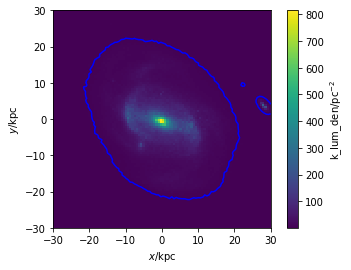

In [8]:
image = pynbody.plot.sph.image(s.star, qty='k_lum_den', units = 'pc^-2', width='60 kpc', log=False, clear=False, noplot=False, resolution = 100)

cs = plt.contour(pynbody.plot.stars.convert_to_mag_arcsec2(image), levels = [20], extent = [-30,30,-30,30], colors = 'b')
p = cs.allsegs

cs_len = 0
for i in range(0,len(p[0])):
    if cs_len<len(p[0][i]):
        cs_len = len(p[0][i])
        cs_i = i

a = fitEllipse(p[0][cs_i][:,0],p[0][cs_i][:,1])
center = ellipse_center(a)
#phi = ellipse_angle_of_rotation(a)
phi = ellipse_angle_of_rotation2(a)
axes = ellipse_axis_length(a)

# get the individual axes
a, b = axes

In [12]:
print(a,b,phi * 180 / np.pi + 90)

17.97574373385035 24.44499078500654 218.4982300939294


In [16]:
phi * 180 / np.pi

128.4982300939294

Text(15,23,'$\\epsilon$ = 0.68')

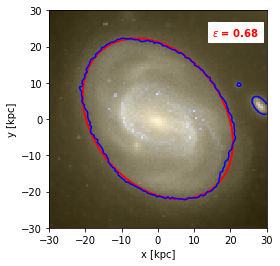

In [14]:
image = pynbody.plot.sph.image(s.star, qty='k_lum_den', units = 'pc^-2', width='60 kpc', log=False, clear=False, noplot=True, resolution = 100)
rgb = pynbody.plot.stars.render(s, width = '60 kpc', resolution = 100, dynamic_range = 4,plot = True,ret_im = True)

cs = plt.contour(pynbody.plot.stars.convert_to_mag_arcsec2(image), levels = [20], extent = [-30,30,-30,30], colors = 'b')

ell = Ellipse(center, 2 * a, 2 * b,  phi * 180 / np.pi + 90 , facecolor = 'none',edgecolor = 'r', linewidth = 2) 

plt.gca().add_artist(ell)

#plt.text(-13,-12,"$\mu_{r}$ = 21 [arcsec$^{-2}$]", color = 'b', backgroundcolor = 'white', fontweight = 'semibold')
plt.text(15,23,"$\epsilon$ = "+str(round(np.sqrt(1-(a/b)**2),2)), color = 'r', backgroundcolor = 'white', fontweight = 'semibold')

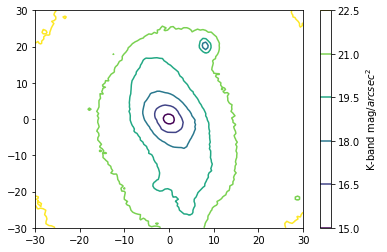

In [15]:
plt.contour(pynbody.plot.stars.convert_to_mag_arcsec2(image), extent = [-30,30,-30,30])
cb = plt.colorbar()
cb.set_label("K-band mag/$arcsec^{2}$")

In [ ]:
Mk = pynbody.analysis.luminosity.halo_mag(h0, band = 'k')

In [ ]:
Mk